In [10]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import sys
import os
sys.path.append(os.path.abspath(".."))
import kagglehub

# Import own modules
from train.train import SimplePetClassifer
from utils_inference import predict, visualize_predictions, get_predicted_label

# Download latest version of the dataset from Kaggle
path = kagglehub.dataset_download("tongpython/cat-and-dog")


In [11]:
# Set subclass of Dataset for kaggle Dataset
class PetDataSet(Dataset):
    def __init__(self, data_dir: str, transform: torch.nn.Module = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int):
        return self.data[idx]
    
    @property
    def classes(self) -> list[str]:
        return self.data.classes
    
# Define test folder path
test_folder = os.path.join(path, "test_set/test_set")
# Define transformations and create DataLoaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = PetDataSet(test_folder, transform=transform)
# Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(test_folder).class_to_idx.items()}
print("Classes found:", target_to_class)

# Load the trained model
model_path = "../models/pretrained_classifier.pth"  # or "scratch_classifier.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please train the model first.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePetClassifer()
model.load_state_dict(torch.load(model_path,weights_only=True))
model.to(device);

Classes found: {0: 'cats', 1: 'dogs'}


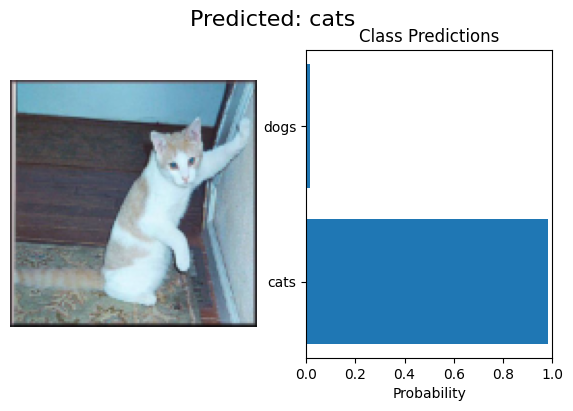

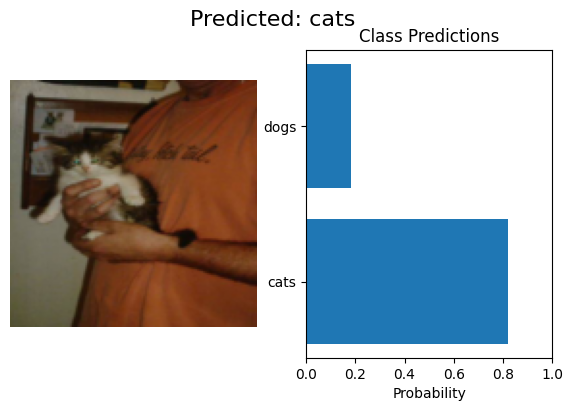

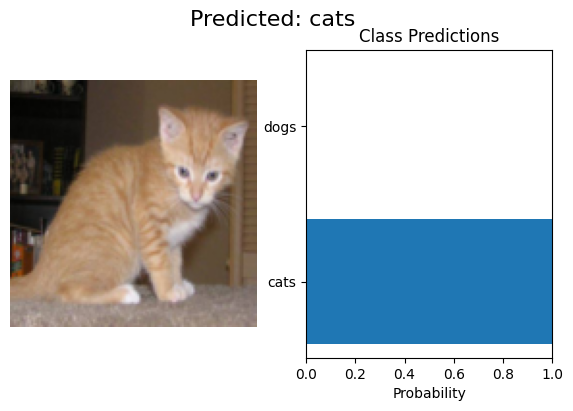

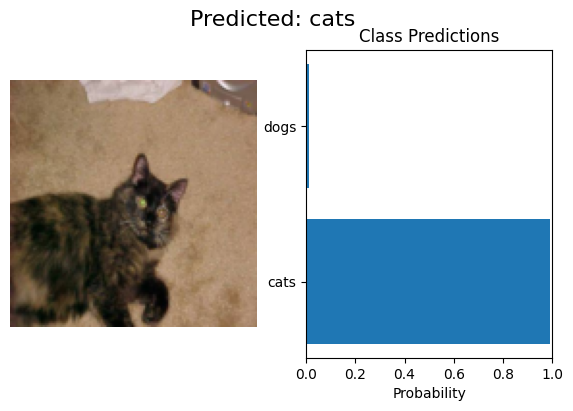

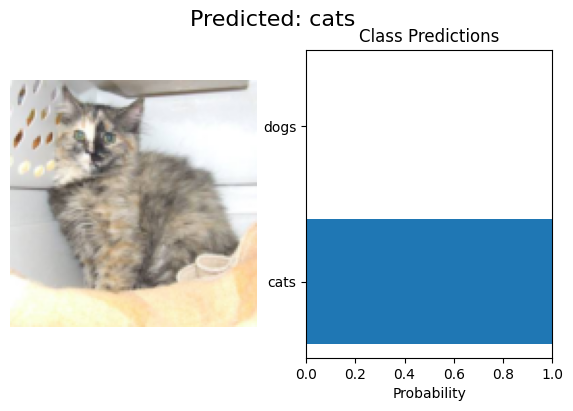

In [12]:
# Get inference on test dataset e.g. first 5 images
for i,item in enumerate(test_dataset):
    if i>=5:
        break
    # Get image and label from dataset and transform into correct format
    image, label = item
    original_image, image_tensor = image, image.unsqueeze(0)
    # Get prediction and visualize
    probabilities = predict(model, image_tensor, device)
    visualize_predictions(original_image.permute(1, 2, 0).numpy(), probabilities, test_dataset.classes)
    
    

Example 8: True label: cats, Predicted: dogs


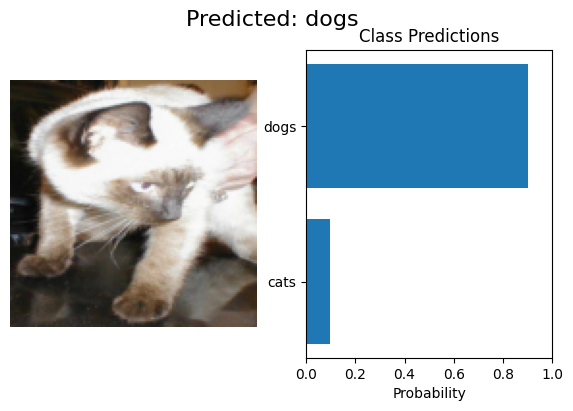

Example 32: True label: cats, Predicted: dogs


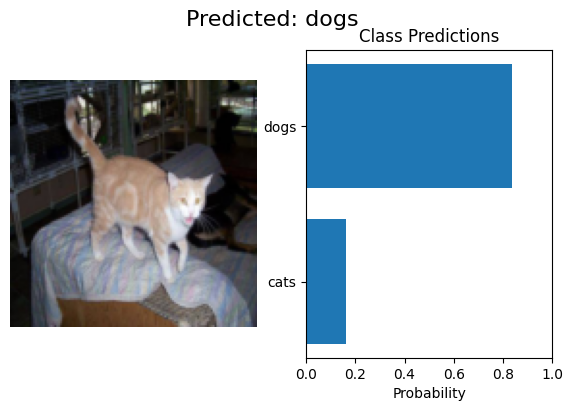

Example 41: True label: cats, Predicted: dogs


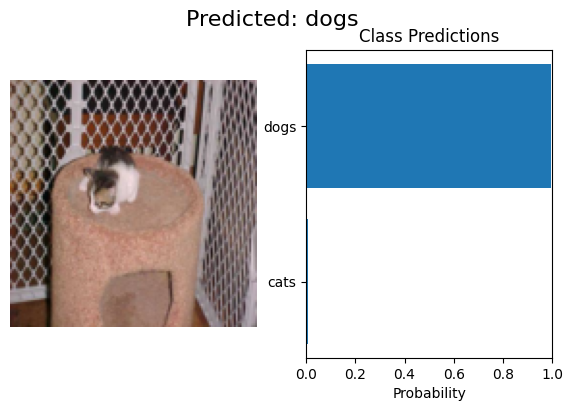

Example 74: True label: cats, Predicted: dogs


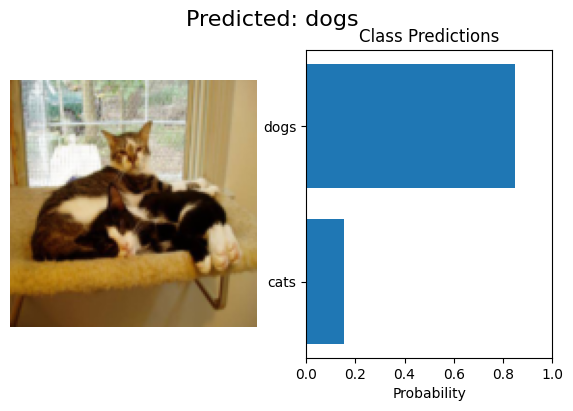

Example 84: True label: cats, Predicted: dogs


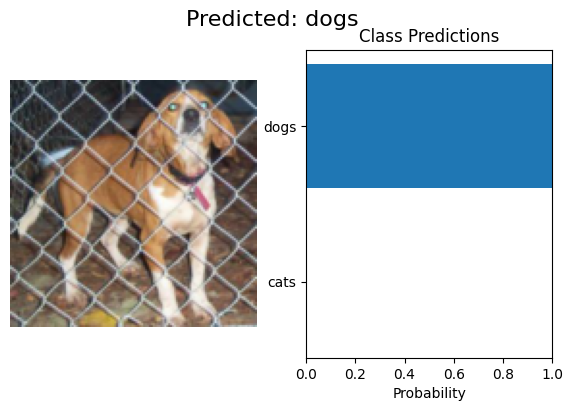

Example 85: True label: cats, Predicted: dogs


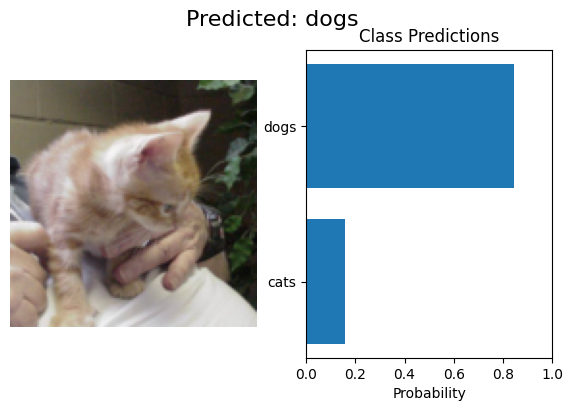

Example 99: True label: cats, Predicted: dogs
Example 103: True label: cats, Predicted: dogs
Example 124: True label: cats, Predicted: dogs
Example 156: True label: cats, Predicted: dogs
Example 157: True label: cats, Predicted: dogs
Example 192: True label: cats, Predicted: dogs
Example 223: True label: cats, Predicted: dogs
Example 224: True label: cats, Predicted: dogs
Example 238: True label: cats, Predicted: dogs
Example 240: True label: cats, Predicted: dogs
Example 313: True label: cats, Predicted: dogs
Example 350: True label: cats, Predicted: dogs
Example 361: True label: cats, Predicted: dogs
Example 364: True label: cats, Predicted: dogs
Example 394: True label: cats, Predicted: dogs
Example 398: True label: cats, Predicted: dogs
Example 410: True label: cats, Predicted: dogs
Example 417: True label: cats, Predicted: dogs
Example 474: True label: cats, Predicted: dogs
Example 521: True label: cats, Predicted: dogs
Example 596: True label: cats, Predicted: dogs
Example 628: T

In [13]:
# Iterate over the whole test dataset and only show wrong predictions
number_of_misclassified = 0  # Counter for misclassified images
number_of_wrong_cats = 0 # Counter for misclassified cats
number_of_wrong_dogs = 0 # Counter for misclassified dogs
number_of_plots = 5 # After this many wrong predictions, stop plotting for santity
for i, item in enumerate(test_dataset):
    # Prepare image and label
    image, label = item
    original_image, image_tensor = image, image.unsqueeze(0)
    # Predict and get probabilities
    probabilities = predict(model, image_tensor, device)
    predicted_label = get_predicted_label(probabilities, target_to_class)
    if predicted_label != test_dataset.classes[label]:
        print(f"Example {i}: True label: {test_dataset.classes[label]}, Predicted: {predicted_label}")
        if number_of_misclassified <= number_of_plots:
            visualize_predictions(original_image.permute(1, 2, 0).numpy(), probabilities, test_dataset.classes)
        number_of_misclassified += 1
        if test_dataset.classes[label] == 'cats':
            number_of_wrong_cats += 1
        else:
            number_of_wrong_dogs += 1

print(f"Total misclassified images: {number_of_misclassified} out of {len(test_dataset)}")
print(f"Total misclassified cats: {number_of_wrong_cats}")
print(f"Total misclassified dogs: {number_of_wrong_dogs}")
print(f"Accuracy on test set: {(len(test_dataset) - number_of_misclassified) / len(test_dataset) * 100:.2f}%")